In [1]:

!pip install fastai
!pip install timm

In [2]:
from fastai.vision.all import *

/home/dnth/anaconda3/envs/timm-edge/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
trn_path = Path('../data/train_images')

In [20]:
aug_transforms??

Signature:
aug_transforms(
    mult: 'float' = 1.0,
    do_flip: 'bool' = True,
    flip_vert: 'bool' = False,
    max_rotate: 'float' = 10.0,
    min_zoom: 'float' = 1.0,
    max_zoom: 'float' = 1.1,
    max_lighting: 'float' = 0.2,
    max_warp: 'float' = 0.2,
    p_affine: 'float' = 0.75,
    p_lighting: 'float' = 0.75,
    xtra_tfms: 'list' = None,
    size: 'int | tuple' = None,
    mode: 'str' = 'bilinear',
    pad_mode='reflection',
    align_corners=True,
    batch=False,
    min_scale=1.0,
)
Source:   
def aug_transforms(
    mult:float=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`
    do_flip:bool=True, # Random flipping
    flip_vert:bool=False, # Flip vertically
    max_rotate:float=10., # Maximum degree of rotation
    min_zoom:float=1., # Minimum zoom 
    max_zoom:float=1.1, # Maximum zoom 
    max_lighting:float=0.2, # Maximum scale of changing brightness 
    max_warp:float=0.2, # Maximum value of changing warp per
    p_affine:float=0.75, # 

In [4]:
dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, 
                                item_tfms=[Resize((224, 224))], batch_tfms=aug_transforms(min_scale=0.75))


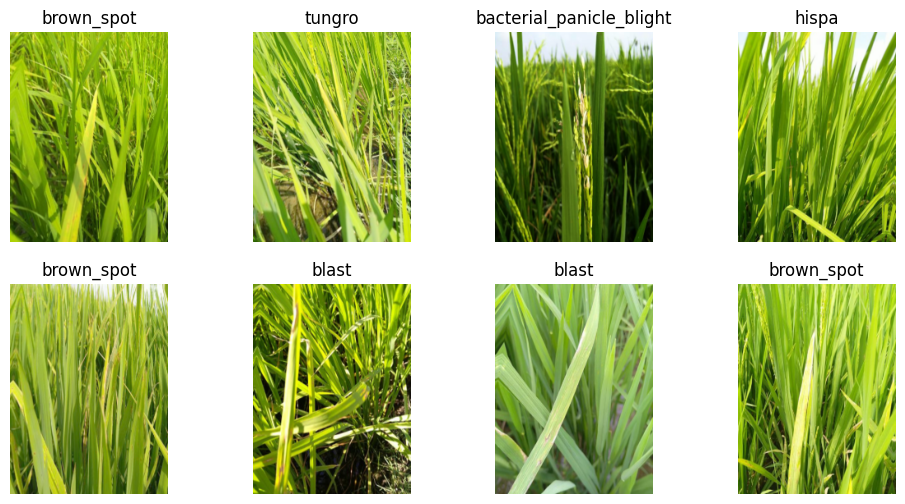

In [5]:
dls.train.show_batch(max_n=8, nrows=2)

In [12]:
import timm
timm.list_models('*edge*')

['cs3edgenet_x',
 'cs3se_edgenet_x',
 'edgenext_base',
 'edgenext_small',
 'edgenext_small_rw',
 'edgenext_x_small',
 'edgenext_xx_small']

In [13]:
learn = vision_learner(dls, 'edgenext_small', metrics=accuracy).to_fp16()

Downloading: "https://github.com/mmaaz60/EdgeNeXt/releases/download/v1.1/edgenext_small_usi.pth" to /home/dnth/.cache/torch/hub/checkpoints/edgenext_small_usi.pth


SuggestedLRs(valley=0.0030199517495930195)

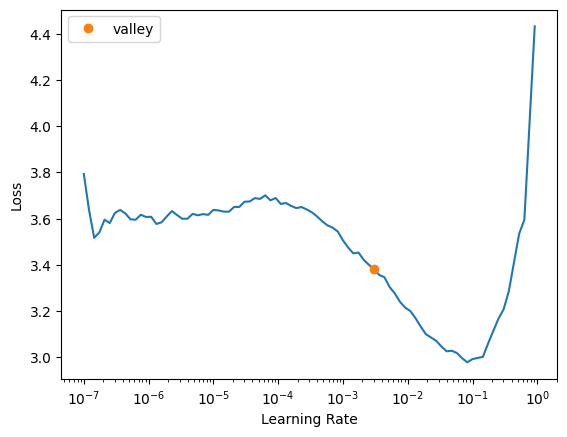

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.687637,1.169058,0.641038,00:37


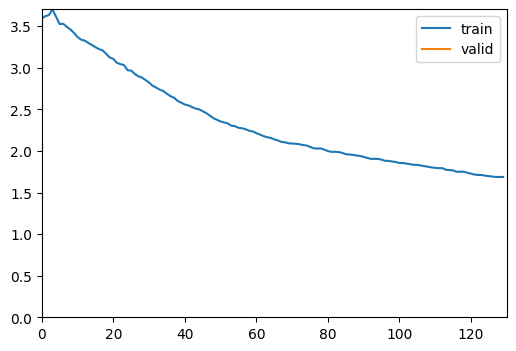

epoch,train_loss,valid_loss,accuracy,time
0,0.990729,0.662208,0.770783,00:39
1,0.787801,0.553468,0.814512,00:38
2,0.580139,0.384235,0.881788,00:39
3,0.443858,0.306419,0.906295,00:39
4,0.359053,0.284449,0.908217,00:44


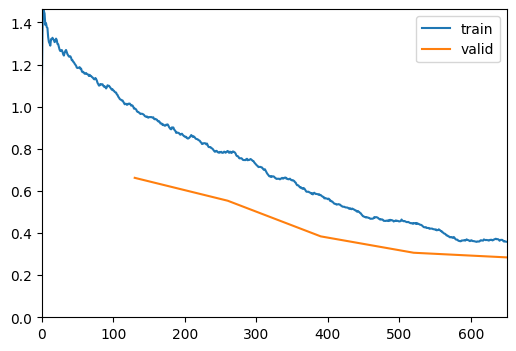

In [15]:
learn.fine_tune(5, base_lr=1e-2, cbs=[ShowGraphCallback()])

In [16]:
learn.export("../../train/export.pkl")

In [17]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

learn.model.cpu()
learn.model.eval();
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(learn.model, example)
optimized_traced_model = optimize_for_mobile(traced_script_module)
optimized_traced_model._save_for_lite_interpreter("model.pt")